In [4]:
import numpy as np
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss, MSELoss
from pennylane import NesterovMomentumOptimizer
from qcnn.qcnn import QCNN

dims = (16, 16), (28, 28), (32, 32)
num_trials = 10

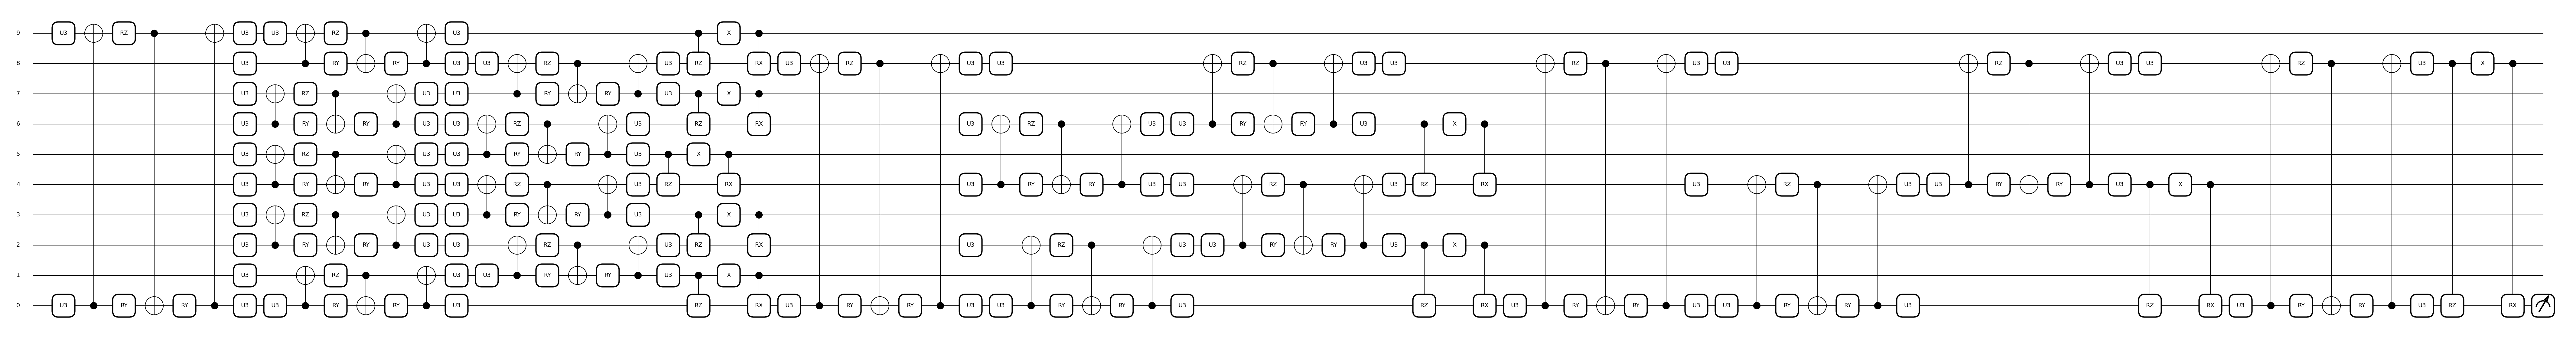

In [5]:
# from thesis.quantum.operation.ansatz.convolution.v5 import ConvolutionAnsatz as A
from qcnn.quantum.operation.ansatz import BaselineAnsatz as A
from qcnn.ml.data import BinaryData
from qcnn.ml.optimize import Optimizer
from qcnn.ml.data import image_transform
from qcnn.experiment import Experiment
from qcnn.cnn import CNN

dims = (28, 28)
num_layers = 4
silent = False

data = BinaryData(FashionMNIST, image_transform(dims, flatten=True), batch_size=(500, 1000))
# optimizer = Optimizer(SGD, lr=0.01, momentum=0.9, nesterov=True)
optimizer = Optimizer(Adam)
qcnn = QCNN.with_logging(data, optimizer, CrossEntropyLoss(), epoch=25)

qcnn.ansatz = A.from_dims(dims, num_layers=num_layers)
circuit_drawing = qcnn.ansatz.draw(decompose=True)

In [6]:
experiment = Experiment(qcnn, num_trials, results_schema=["accuracy"])
# results = experiment(dims, num_layers, silent=silent)
results = experiment(A, dims, silent=silent, num_layers=num_layers)

2023-06-07 16:32:56,916: (qcnn_trial_0) Number of Parameters: 68


KeyboardInterrupt: 

In [ ]:
from pathlib import Path
from qcnn.file import save_dataframe_as_csv

name = "3"
path = Path(f"results/{name}")
save_dataframe_as_csv(path.with_suffix(".csv"), results)

(0.6305, 0.6305, 0.0)

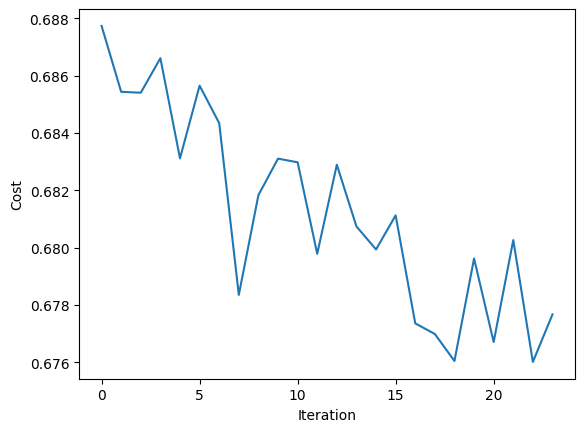

In [ ]:
fig, = experiment.draw()

fig.savefig(path.with_suffix(".png"))

acc = results["accuracy"]
acc.median(), acc.mean(), acc.std()

Variables to consider:
- __batch, epoch__
- Operation on "ancilla" qubits (pre, post, none)
- Filter Ansatz
- Fully-connected Ansatz
- Which qubits to apply Fully-connected
- Which qubits to measure